In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt

%matplotlib inline

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [5]:
import requests
from io import StringIO

In [8]:
data = pd.read_csv("efron-morris-75-data.tsv", sep="\t")
at_bats, hits = data[["At-Bats", "Hits"]].to_numpy().T

In [9]:
data

,FirstName,LastName,At-Bats,Hits,BattingAverage,RemainingAt-Bats,RemainingAverage,SeasonAt-Bats,SeasonHits,SeasonAverage
0,Roberto,Clemente,45,18,0.400,367,0.3460,412,145,0.352
1,Frank,Robinson,45,17,0.378,426,0.2981,471,144,0.306
2,Frank,Howard,45,16,0.356,521,0.2764,566,160,0.283
3,Jay,Johnstone,45,15,0.333,275,0.2218,320,76,0.238
4,Ken,Berry,45,14,0.311,418,0.2727,463,128,0.276
5,Jim,Spencer,45,14,0.311,466,0.2704,511,140,0.274
6,Don,Kessinger,45,13,0.289,586,0.2645,631,168,0.266
7,Luis,Alvarado,45,12,0.267,138,0.2101,183,41,0.224
8,Ron,Santo,45,11,0.244,510,0.2686,555,148,0.267
9,Ron,Swaboda,45,11,0.244,200,0.2300,245,57,0.233


In [10]:
N = len(hits)
player_names = data["FirstName"] + " " + data["LastName"]
coords = {"player_names": player_names.tolist()}

with pm.Model(coords=coords) as baseball_model:
    phi = pm.Uniform("phi", lower=0.0, upper=1.0)

    kappa_log = pm.Exponential("kappa_log", lam=1.5)
    kappa = pm.Deterministic("kappa", pt.exp(kappa_log))

    theta = pm.Beta("theta", alpha=phi * kappa, beta=(1.0 - phi) * kappa, dims="player_names")
    y = pm.Binomial("y", n=at_bats, p=theta, dims="player_names", observed=hits)

In [11]:
with baseball_model:
    theta_new = pm.Beta("theta_new", alpha=phi * kappa, beta=(1.0 - phi) * kappa)
    y_new = pm.Binomial("y_new", n=4, p=theta_new, observed=0)

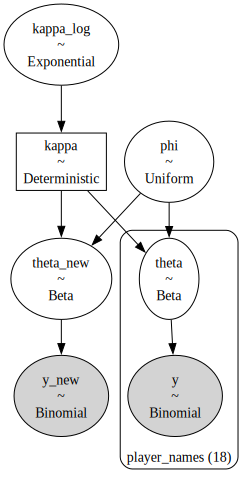

In [12]:
pm.model_to_graphviz(baseball_model)

In [13]:
with baseball_model:
    idata = pm.sample(2000, tune=2000, chains=2, target_accept=0.95)

    # check convergence diagnostics
    assert all(az.rhat(idata) < 1.03)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [phi, kappa_log, theta, theta_new]


Output()

Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'phi'}>, <Axes: title={'center': 'phi'}>],
       [<Axes: title={'center': 'kappa'}>,
        <Axes: title={'center': 'kappa'}>]], dtype=object)

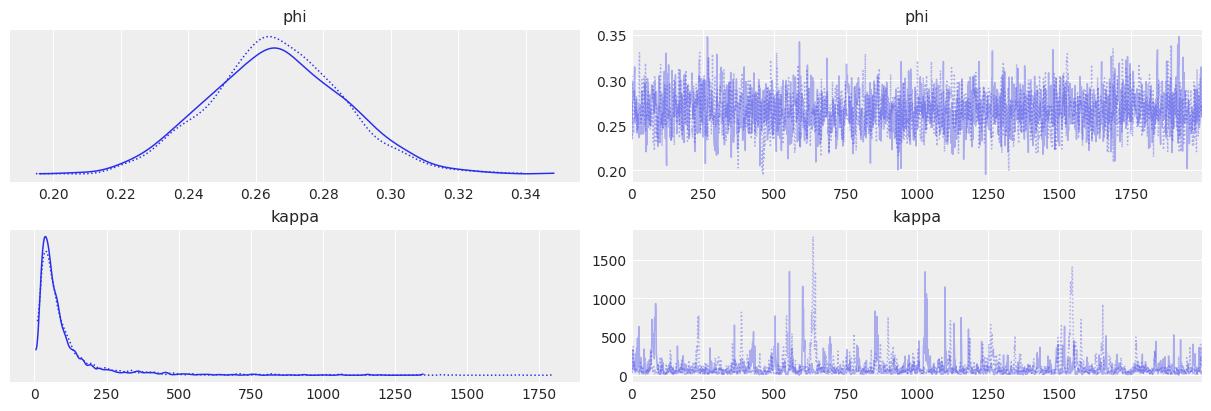

In [14]:
az.plot_trace(idata, var_names=["phi", "kappa"])